# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 2
# Linear and k-NN Regression


**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook even if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline

# Predicting Taxi Pickups in NYC

In this homework, we will explore k-nearest neighbor, linear and polynomial regression methods for predicting a quantitative variable. Specifically, we will build regression models that can predict the number of taxi pickups in New York city at any given time of the day. These prediction models will be useful, for example, in monitoring traffic in the city.

The data set for this problem is given in files `dataset_1_train.txt` and `dataset_1_test.txt` as separate training and test sets. The first column in each file contains the time of a day in minutes, and the second column contains the number of pickups observed at that time. The data set covers taxi pickups recorded during different days in Jan 2015 (randomly sampled across days and time of that day).

We will fit regression models that use the time of the day (in minutes) as a predictor and predict the average number of taxi pick ups at that time. The models will be fitted to the training set, and  evaluated on the test set. The performance of the models will be evaluated using the $R^2$ metric. 

**Data Normalization:** As a first step, we suggest that you normalize the `TimeMin` predictor to a value between 0 and 1. This can be done by dividing the time column in the training and test sets by 1440 (i.e. the maximum value the predictor can take). This normalization step would be particularly helpful while fitting polynomial regression models on this data.

# Part (0): EDA

Generate a scatter plot of the training data points, with the time of the day on the X-axis and the number of taxi pickups on the Y-axis. Does the pattern of taxi pickups make intuitive sense to you?

Let's read in the training data and normalize the time as suggested and compute the time in hours.

In [2]:
def normalize_data(data):
    data['TimeMinNorm'] = data.TimeMin / (24 * 60)
    data['TimeHour'] = data.TimeMin / 60
    return data

In [3]:
train_data = pd.read_csv('../hwassets/data/dataset_1_train.txt')
train_date = normalize_data(train_data)
train_data.head()

,TimeMin,PickupCount,TimeMinNorm,TimeHour
0,860.0,33.0,0.597222,14.333333
1,17.0,75.0,0.011806,0.283333
2,486.0,13.0,0.337500,8.100000
3,300.0,5.0,0.208333,5.000000
4,385.0,10.0,0.267361,6.416667


In [4]:
def plot_training_data(axes):
    train_data.plot(x='TimeHour', y='PickupCount', kind='scatter',
                    label='training data',
                    marker='+', color='grey', ax=axes)
    axes.set(title='Number of taxi pickups in New York City',
             xlabel='Time of day (hours)', ylabel='Number of taxi pickups');
    axes.set_xticks(range(0, 27, 3));
    axes.set_yticks(range(0, 120, 20))
    axes.legend();

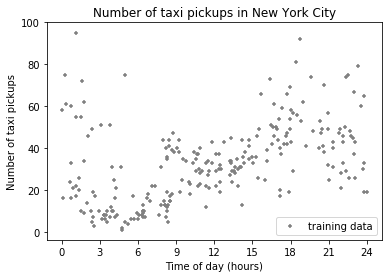

In [5]:
plot_training_data(plt.axes());

The pattern of taxi pickups seems to make intuitive sense for a city like New York. The number of pickups is at a minimum during usual working and commuting hours (6-18 hours) and at a maximum during the evening. However, there are pickups throughout the day in the city.

# Part (a): k-Nearest Neighbors

We begin with k-Nearest Neighbors (k-NN), a non-parametric regression technique. You may use `sklearn`'s built-in functions to run k-NN regression. Create a `KNeighborsRegressor` object, use the `fit` method in the object to fit a k-NN regressor model, use the `predict` method to make predictions from the model, and the `score` method to evaluate the $R^2$ score of the model on a data set.

- Fit k-NN regression models:
    - Fit a k-NN regression model to the training set for different values of $k$ (e.g. you may try out values 1, 2, 10, 25, 50, 100 and 200). 
    - If you are using `sklearn`'s built-in functions for k-NN regression, explain what happens when you invoke the `fit` function. 
    - If $n$ is the number of observations in the training set, what can you say about a k-NN regression model that uses $k = n$?
- Visualize the fitted models: 
    - Generate a scatter plot of the training data points, and in the same figure, also generate line plots of the predicted values $\hat{y}$ from each fitted model as a function of the predictor variable $x$. (*Hint:* you will want to sort the $x$ values before plotting.)
    - How does the value of $k$ effect the fitted model?
- Evaluate the fitted models:
    - Compute the $R^2$ score for the fitted models on both the training and test sets. Are some of the calculated $R^2$ values negative? If so, what does this indicate? What does a $R^2$ score of 0 mean?
    - Make plots of the training and test $R^2$ values as a function of $k$. Do the training and test $R^2$ plots exhibit different trends? Explain how the value of $k$ influences the training and test $R^2$ values.

We set the values of k, the number of nearest neighbours

In [6]:
ks = [1, 2, 10, 25, 50, 100, 200]

We fit the k-NN regression models using the `fit` function of the `KNeighborsRegressor` class in sklearn. This function uses the training data inputs and target values to fit the model. It does this by calculating for each training point in the input space, the distance to all the other training points. Then the algorithm fits the target value of this point to be the mean of the target values of the k closest points in the input space.

If n is the number of observations in the training set then the k-NN model where k=n fits the target value of every training point as the mean target value of the entire training set.

In [7]:
X_train = train_data.TimeMin.values.reshape(-1, 1)
y_train = train_data.PickupCount.values.reshape(-1, 1)
knn_models = {}
for k in ks:
    knn = KNeighborsRegressor(n_neighbors=k)
    model = knn.fit(X=X_train, y=y_train)
    knn_models[k] = model

Let's read in the test data and normalize the time as suggested and compute the time in hours.

In [8]:
test_data = pd.read_csv('../hwassets/data/dataset_1_test.txt')
test_date = normalize_data(test_data)
test_data.head()

,TimeMin,PickupCount,TimeMinNorm,TimeHour
0,925.0,43.0,0.642361,15.416667
1,559.0,33.0,0.388194,9.316667
2,1277.0,41.0,0.886806,21.283333
3,1114.0,61.0,0.773611,18.566667
4,784.0,29.0,0.544444,13.066667


Let's make predictions on the train and test sets using the fitted models.

In [9]:
def make_model_predictions(Xs, data, models):
    predicts = data[['TimeMin', 'TimeMinNorm', 'TimeHour']].copy()
    for k, model in models.items():
        if isinstance(Xs, dict):
            y_predict = model.predict(Xs[k])
        else:
            y_predict = model.predict(Xs)
        predicts['PickupCount_k_' + str(k)] = y_predict
    return predicts

In [10]:
train_predicts = make_model_predictions(train_data.TimeMin.values.reshape(-1, 1),
                                        train_data, knn_models)
train_predicts = train_predicts.sort_values(by='TimeMin')
test_predicts = make_model_predictions(test_data.TimeMin.values.reshape(-1, 1),
                                       test_data, knn_models)
test_predicts = test_predicts.sort_values(by='TimeMin')

Let's visualize the model predictions.

In [11]:
def plot_predicted_values(predicts):
    columns = [col for col in predicts.columns.values
               if col.startswith('PickupCount_k_')]
    axes = predicts.plot(x='TimeHour', y=columns);
    plot_training_data(axes)
    plt.title('Predicted values for number of taxi pickups in'
              '\nNew York City from KNN models')
    labels = [col[col.rfind('k_'):].replace('_', '=')
              for col in columns] + ['training data']
    plt.legend(labels, loc='lower center', bbox_to_anchor=(0.5, -0.35),
               ncol=4);

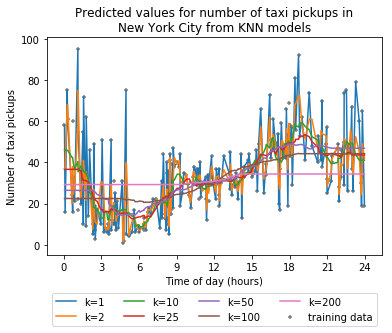

In [12]:
plot_predicted_values(train_predicts)

We can see that the value of $k$ affects the quality of the fitted model. When $k=1$ the model fits through the training points extremely well effectively matching the target values at most points. As $k$ increases, the model fit to the training set gets progressively worse as we see the *averaging* effect of the KNN algorithm. We see that as $k \to n$ the target value of every training point is converging towards the mean target value of the entire training set. Another way to describe this is as k increases we are increasing the bias and reducing the variance.

Let's now compute the $R^{2}$ scores for the fitted models on both the training and test sets.

In [13]:
def compute_r_squared(y_true, model_predicts):
    models_r_squared = []
    columns = [col for col in model_predicts.columns.values
               if col.startswith('PickupCount_k_')]
    for k, col in enumerate(columns):
        y_pred = model_predicts[col]
        r_squared = r2_score(y_true, y_pred)
        models_r_squared.append(r_squared)
    return pd.Series(data=models_r_squared, index=columns)

In [14]:
y_train_sorted_by_time = train_data.sort_values(
    by='TimeMin').PickupCount.values.reshape(-1, 1)
train_r_squared = compute_r_squared(y_train_sorted_by_time, train_predicts)
y_test_sorted_by_time = test_data.sort_values(
    by='TimeMin').PickupCount.values.reshape(-1, 1)
test_r_squared = compute_r_squared(y_test_sorted_by_time, test_predicts)

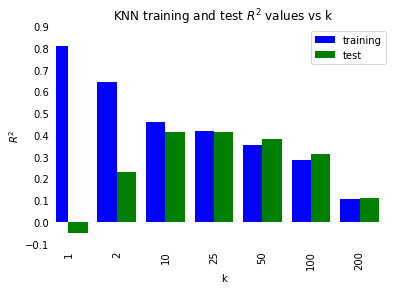

In [15]:
train_r_squared.plot(kind='bar', color='blue', position=1, width=0.4,
                     label='training')
axes = test_r_squared.plot(kind='bar', color='green', position=0,
                           width=0.4, label='test')
axes.set_title('KNN training and test $R^{2}$ values vs k')
axes.set_xticklabels(ks)
axes.set_xlabel('k')
axes.set_ylabel('$R^{2}$')
axes.set_yticks(np.linspace(-0.1, 0.9, 11))
axes.set_frame_on(False)
axes.tick_params(bottom=False, left=False)
axes.legend();

We can see that as $k$ (the number of nearest neighbors) decreases, the training $R^{2}$ increases. Basically, the predictor (time of day) explains more of the variance in the response (taxi pickup count) as $k$ decreases since the model fits the training data better and better. However, for the test set, $R^{2}$ increases upto a $k$ value of 10 and then it decreases, thereafter. So after $k=10$ we see that the models are overfitting and generalizing worse.

The $R^{2}$ value for the test set for $k=1$ is negative. A negative $R^{2}$ value means that the model predicts the test set extremely poorly. In fact it predicts the response variable in the test set worse than the null hypothesis (i.e. using the mean value of the response variable). Effectively, the sum of squared errors for the model is greater than the sum of squared errors if the mean value of the response variable is used. See the following link for more details on [negative coefficient of determination](https://stats.stackexchange.com/questions/12900/when-is-r-squared-negative). 

An $R^{2}$ value of 0 means that the predictor in the model explains none of the variance in the response variable. Basically it cannot predict the response variable.

# Part (b): Simple Linear Regression

We next consider parametric approaches for regression, starting with simple linear regression, which assumes that the response variable has a linear relationship with the predictor. Do you see any advantages in using a parametric regression model over k-NN regression?

We suggest that you use the `statsmodels` module for linear regression. This module has built-in functions to summarize the results of regression, and to compute confidence intervals for estimated regression parameters. Create a `OLS` class instance, use the `fit` method in the instance for fitting a linear regression model, and use the `predict` method to make predictions. To include an intercept term in the regression model, you will need to append a column of 1's to the array of predictors using the `sm.add_constant` method. The `fit` method returns a `results` instance. Use the  `results.summary` method to obtain a summary of the regression fit, the `results.params` attribute to get the estimated regression parameters, and the `conf_int` method to compute confidence intervals for the estimated parameters. You may use the `r2_score` function to compute $R^2$.

Using the suggested built-in functions, answer the following questions:

- Fit a linear regression model to the training set, and evaluate its $R^2$ value on both the training and test sets (you may notice something peculiar about how they compare). 
- How does the test $R^2$ score compare with the best test $R^2$ value obtained with k-NN regression in Part (a)?

- Compute confidence intervals:
    - Print the slope and intercept values for the fitted linear model. What does the sign of the slope convey about the data?
    - Compute the 95% confidence interval for the slope and intercept. Based on this information, do you consider the estimates of the model parameters to be reliable?
    - Do you expect a 99% confidence interval for the slope and intercept to be tighter or looser than the 95% confidence intervals? Briefly explain your answer.

- Analyze residual plots:
    - Make a plot of the residuals ${e} = y - \hat{y}$ of the model on the training set as a function of the predictor variable $x$ (i.e. time of day). Draw a horizontal line denoting the zero residual value on the Y-axis.
    - Using this residual plot, comment on whether the assumption of linearity is valid for this data.

Let's first fit an ordinary least squares linear regression model to the training and test data

In [16]:
X_train_sm = sm.add_constant(X_train)
ols = OLS(y_train, X_train_sm)
ols_results = ols.fit()
X_test = test_data.TimeMin.values.reshape(-1, 1)
X_test_sm = sm.add_constant(X_test)
y_test = test_data.PickupCount.values
ols_test_predicts = ols_results.predict(X_test_sm)
ols_test_r_squared = r2_score(y_true=y_test, y_pred=ols_test_predicts)
print('Training R^2 = ', ols_results.rsquared)
print('Test R^2 = ', ols_test_r_squared)
max_test_r_squared = test_r_squared.max()
k_for_max_test_r_squared = test_r_squared.index[test_r_squared.values.argmax()]
k_for_max_test_r_squared = k_for_max_test_r_squared[
    k_for_max_test_r_squared.rfind('k_'):].replace('_', '=')
print('Best test R^2 for KNN models = {0} (for {1})'.format(
    max_test_r_squared, k_for_max_test_r_squared))

Training R^2 =  0.20721375209894033
Test R^2 =  0.24771232994848646
Best test R^2 for KNN models = 0.41638221253409347 (for k=10)


The perculiar thing is that the test $R^{2}$ is above the training $R^{2}$ which is not usually the case. 

Also, the test $R^{2}$ for this linear regression model is lower than the best value for the KNN model.

Let's take a look at the slope and intercept of the fitted linear model.

In [17]:
print('Intercept = ', np.round(ols_results.params[0], 0))
print('Slope = ', np.round(ols_results.params[1], 2))

Intercept =  18.0
Slope =  0.02


The slope is positive which means for an increase in time there is a predicted associated increase in the pickup count. Precisely, for every minute increase in time, the predicted associated increase in pickup count is approximately 0.021.

Now, let's see what the 95% confidence intervals of the model parameters are.

In [18]:
conf_int_95 = ols_results.conf_int()
print('95% confidence intervals for the parameters are:')
print('Incercept =', np.array2string(np.round(conf_int_95[0], 0),
                                     separator=', '))
print('Slope =', np.array2string(np.round(conf_int_95[1], 3), separator=', '))

95% confidence intervals for the parameters are:
Incercept = [14., 22.]
Slope = [0.016, 0.026]


We can be reasonably confident about the estimate of the slope being 0.02 looking at the confidence interval (evaluating the slope to more than two decimal places doesn't make much sense). 

However, we are far less confident about the estimate of the intercept being 18 (evaluating the intercept to anything other than integers doesn't make much sense). Also, the intercept has no meaning so we really shouldn't try to interpret it.

The $\alpha$ level of the confidence interval tells us that if we estimate the parameter values using many samples that we would expect a fraction of $1-\alpha$ where the true parameter values would lie outside the confidence interval. So for 99% and 95% confidence intervals of the slope and intercept, we would expect the true parameter value to lie outside the interval 1% and 5% of time respectively. Therefore, the 99% confidence interval would be expected to be looser than the 95% confidence interval. I will demonstrate this now.

In [19]:
conf_int_99 = ols_results.conf_int(alpha=0.01)
print('99% confidence intervals for the parameters are:')
print('Incercept =', np.array2string(np.round(conf_int_99[0], 0),
                                     separator=', '))
print('Slope =', np.array2string(np.round(conf_int_99[1], 3), separator=', '))

99% confidence intervals for the parameters are:
Incercept = [13., 24.]
Slope = [0.014, 0.028]


Now let us take a look at the training data residuals.

In [20]:
ols_train_predicts = ols_results.predict(X_train_sm)
ols_train_residuals = y_train.reshape(-1, 1) - ols_train_predicts.reshape(-1, 1)

In [21]:
def plot_residuals(time, residuals, y_range=(-40, 100), sub_title=None):
    title = 'New York City Taxi pickups: \nTraining set residuals'
    if sub_title:
        title += '\n' + sub_title

    plt.scatter(time, residuals, s=3.0, label='residuals');
    plt.axhline(label='zero error', color='green', linewidth=0.6)
    plt.title(title)
    plt.xlabel('Time of day (hours)')
    plt.ylabel('Residual');
    plt.xticks(range(0, 27, 3));
    plt.yticks(range(y_range[0], y_range[1], 20));
    plt.legend();

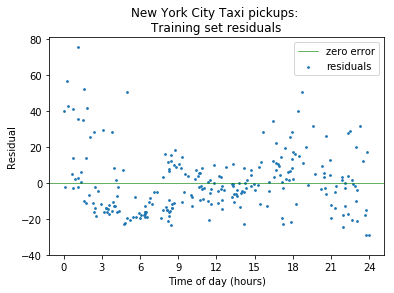

In [22]:
plot_residuals(train_data.TimeHour, ols_train_residuals)

If the assumpion of linearity were valid for this data, then the errors (the residuals) would be consistent with stochastic noise, That is, they would be randomly scattered but centered on zero error, with no discernible pattern. Clearly, looking at the residual plot, we can see that it is possible to predict the value of the residual based on the value of the predictor (the time of day).

# Part (c): Polynomial Regression

We proceed to higher-order polynomial models for regression:

- By visual inspection, what polynomial degree do you think would provide the best fit for the data?

- At the start of this assignment, we had advised you to normalize the time predictor in the training and test sets to a value in [0,1], and noted that this would be helpful in fitting polynomial regression models. Had the time predictor not been normalized, what difficulties in implementing polynomial regression may have occurred?

- Fit polynomial regression models of degrees 2, 3, 10, 25 and 50 to the training set, and generate visualizations of the fitted models (in the same figure, plot the predicted value from all models as a function of time). 

- Evaluate the $R^2$ value of the fitted models on both the training and test sets. Does a high training $R^2$ value necessarily indicate a high test $R^2$ value? How do the test $R^2$ values from the different polynomial models compare with the test $R^2$ from simple linear regression in Part (b), and the best test $R^2$ from k-NN regression in Part (a)?

- Generate residual plots for the different polynomial regression models (plot of residuals on training set vs. time). How does the increase in polynomial degree effect the residual plots?

*Hint:* You may use the `PolynomialFeatures` class to include polynomial terms in the regression model.

By visual inspection it seems that a polynomial of degree 2 (a quadratic) would be a best fit for the data.

At the start of this assignment, we were advised to normalize the time predictor in the training and test sets to a value in [0,1] as it was noted that this would be helpful in fitting polynomial regression models. Had the time predictor not been normalized, we may have had issues with multicollinearity when implementing polynomial regression. It refers to predictors that are correlated with other predictors in the model. Apparently [multicollinearity](http://blog.minitab.com/blog/adventures-in-statistics-2/when-is-it-crucial-to-standardize-the-variables-in-a-regression-model) is a problem because it can hide statistically significant terms, cause the coefficients to switch signs, and make it more difficult to specify the correct model.

Let's set the value of the polynomial degrees.

In [23]:
degrees = [2, 3, 10, 25, 50]

Now we fit the polynomial regression models.

In [24]:
poly_reg_models = {}
poly_train_Xs = {}
poly_test_Xs = {}
for degree in degrees:
    poly = PolynomialFeatures(degree=degree)
    X_train_norm = train_data.TimeMinNorm.values.reshape(-1, 1)
    X_train_with_poly = poly.fit_transform(X=X_train_norm, y=y_train)
    X_test_norm = test_data.TimeMinNorm.values.reshape(-1, 1)
    X_test_with_poly = poly.fit_transform(X=X_test_norm, y=y_test)
    poly_train_Xs[degree] = sm.add_constant(X_train_with_poly)
    poly_test_Xs[degree] = sm.add_constant(X_test_with_poly)
    poly_reg = OLS(y_train, poly_train_Xs[degree])
    poly_reg_results = poly_reg.fit()
    poly_reg_models[degree] = poly_reg_results

Let's use the polynomial regression models to make predictions on the training and test sets.

In [25]:
train_poly_predicts = make_model_predictions(poly_train_Xs, train_data,
                                             poly_reg_models)
train_poly_predicts = train_poly_predicts.sort_values(by='TimeMin')
test_poly_predicts = make_model_predictions(poly_test_Xs, test_data,
                                            poly_reg_models)
test_poly_predicts = test_poly_predicts.sort_values(by='TimeMin')

Let's visualize how the the fitted models look for the training data as a function of the polynomial degree, k, and take a look at the $R^{2}$ values for the training and test sets.

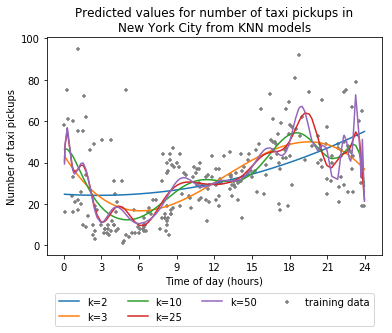

In [26]:
plot_predicted_values(train_poly_predicts)

In [27]:
train_poly_r_squared = compute_r_squared(y_train_sorted_by_time,
                                         train_poly_predicts)
test_poly_r_squared = compute_r_squared(y_test_sorted_by_time,
                                        test_poly_predicts)

In [28]:
def print_r_squared(poly_r_squared):
    for k, r2 in poly_r_squared.items():
        print(k[k.rfind('k_'):].replace('_', '=') + ':', r2)

In [29]:
print('Training R^2 values for polynomials of degree k are:')
print_r_squared(train_poly_r_squared)
print()
print('Test R^2 values for polynomials of degree k are:')
print_r_squared(test_poly_r_squared)
print()
print('Test R^2 from simple linear regression = ', ols_test_r_squared)
print()
print('Best test R^2 for KNN models = {0} (for {1})'.format(
    max_test_r_squared, k_for_max_test_r_squared))

Training R^2 values for polynomials of degree k are:
k=2: 0.2324332710285808
k=3: 0.3748362391177079
k=10: 0.42827706862579074
k=25: 0.4632789800468531
k=50: 0.4890243850611069

Test R^2 values for polynomials of degree k are:
k=2: 0.2557241421619162
k=3: 0.37858436224816683
k=10: 0.40200780068976116
k=25: 0.3836941182515786
k=50: 0.3306418317116554

Test R^2 from simple linear regression =  0.24771232994848646

Best test R^2 for KNN models = 0.41638221253409347 (for k=10)


From the values above we see that a higher training $R^2$ value does not necessarily indicate a higher test $R^2$ value.

We can see that the test $R^2$ values from the different polynomial models are lower than the best test $R^2$ from k-NN regression in Part (a), but higher than the test $R^2$ from simple linear regression in Part (b).

Now let us take a look at how the training data residuals vary with the degree of the polynomial k.

In [30]:
train_poly_predicts.head()

,TimeMin,TimeMinNorm,TimeHour,PickupCount_k_2,PickupCount_k_3,PickupCount_k_10,PickupCount_k_25,PickupCount_k_50
36,4.0,0.002778,0.066667,24.695513,43.120646,46.397246,40.651599,39.307950
56,7.0,0.004861,0.116667,24.676580,42.636364,46.534751,48.646294,48.853601
1,17.0,0.011806,0.283333,24.615962,41.059896,46.416479,55.045680,56.805982
239,19.0,0.013194,0.316667,24.604298,40.751536,46.300197,54.188239,55.850567
10,40.0,0.027778,0.666667,24.491095,37.651263,43.733015,38.908942,38.144552


In [31]:
train_poly_residuals = pd.concat((
    train_poly_predicts[['TimeMin', 'TimeMinNorm', 'TimeHour']].copy(),
    train_poly_predicts.loc[:, 'PickupCount_k_2':'PickupCount_k_50'].subtract(
        y_train_sorted_by_time.reshape(-1,), axis=0).rename(
        mapper=lambda x: x.replace('PickupCount', 'residual'), 
        axis='columns')), axis=1)

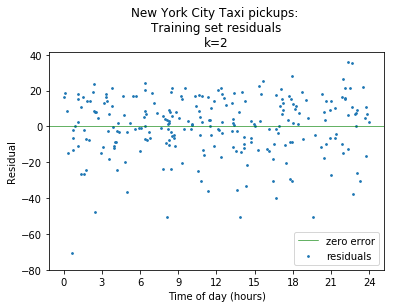

In [32]:
plot_residuals(train_data.TimeHour, train_poly_residuals.residual_k_2,
               y_range=(-80, 60), sub_title='k=2')

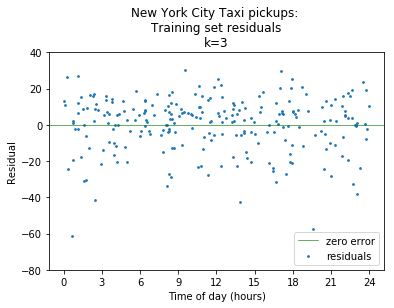

In [33]:
plot_residuals(train_data.TimeHour, train_poly_residuals.residual_k_3,
               y_range=(-80, 60), sub_title='k=3')

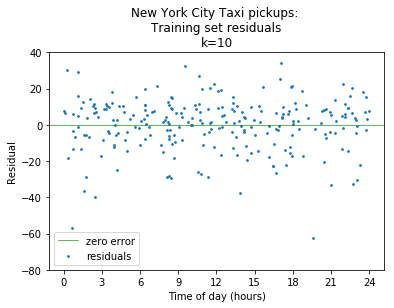

In [34]:
plot_residuals(train_data.TimeHour, train_poly_residuals.residual_k_10,
               y_range=(-80, 60), sub_title='k=10')

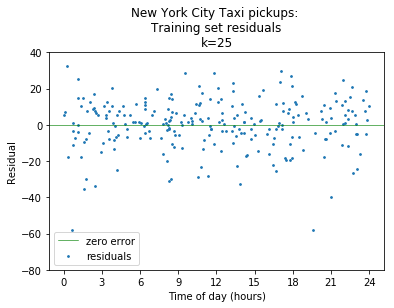

In [35]:
plot_residuals(train_data.TimeHour, train_poly_residuals.residual_k_25, 
               y_range=(-80, 60), sub_title='k=25')

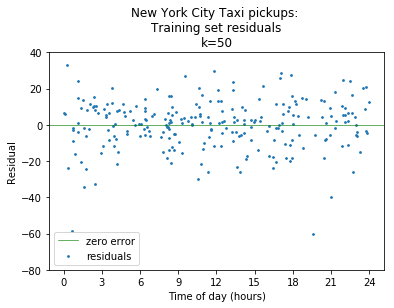

In [36]:
plot_residuals(train_data.TimeHour, train_poly_residuals.residual_k_50,
               y_range=(-80, 60), sub_title='k=50')

Looking at the above residual plots we can see that the increase in polynomial degree k reduces the scatter in the residuals. This makes sense as one would expect a higher polynomial degree more to be more flexible and therefore fit the training data better.

# Part (d): Summarize Results
In a brief paragraph (8 or fewer sentences), summarize which of the models seen above you would choose to predict the number of taxi cab pick-ups at any specific time of day.  Be sure to explain your choice. Interpret the model you choose, including which predictors are significant and provide and interpret the CIs for their coefficients (if you choose a regression model). How well does you model predict the number of taxi cab pick-ups?  How would you improve this model even further?  Feel free to refer to visual(s) above or provide a new one to make your case.



Due to the residual plot in part (b), I would exclude the simple regression model, since the assumption of linearity is not valid. This leaves a choice between the best kNN model (k=10) from part(a) and the best polynomial regression model (degree=10) from part (c). Due to the higher training and test $R^{2}$ values for these models it would suggest that the kNN model (k=10) is the best model. The key point here is that the kNN model (k=10) is the best model for prediction. Additionally, the data is so scattered it does not look like a parametric model like a regression model could fit it. The data seems more amenable to non-parametric model such as kNN whose structure is based on data.

The chosen model (and indeed any of these models) does not predict the number of taxi cab pick-ups very well. To improve predictions, I would suggest cross-validation on a validation set to choose the best k value for the number of nearest neighbors.

---- 


# APCOMP209a - Homework Question

Read Sections 1 and 2 of this [paper](https://www.researchgate.net/profile/Roberto_Togneri/publication/45094554_Linear_Regression_for_Face_Recognition/links/09e4150d243bd8b987000000/Linear-Regression-for-Face-Recognition.pdf). 

Briefly, we have a number of cleaned images of people's faces. The model leverages the concept that "patterns from a single-object class lie on a linear subspace" and the fact that linear regression can be thought of as an orthogonal projection of the response vector (Y) onto the subspace spanned by the columns of the predictor matrix (X).

### Question 1
Consider a space in $\mathbb{R}^5$, with two subspaces $S_0 \subset \mathbb{R}^5$ and $S_1 \subset \mathbb{R}^5$. For simplicity, let us consider the case where the subspace $S_0$ is spanned by the vectors $v_{00} = [1,0,0,0,0]^T$, $v_{01} =[0,1,0,0,0]^T$ and the subspace $S_1$ is spanned by the vectors $v_{10} = [0,0,0,1,0]^T$ and $v_{11} = [0,0,0,0,1]^T$. 

Now let us assume that we have a dataset that consists of labeled vectors in subspaces $S_0$ and $S_1$ respectively. Our task here is to use the data in the training dataset to classify an unknown vector into either $S_0$ or $S_1$.

Let us consider the case where we construct a predictive matrix $\mathbf{X}$ from the 'training' data for which we know the labels (note: is not meant to match $S_0$ and $S_1$ above).

```
dataset = np.array([
            [1,0,0,0,0],
            [1,1,0,0,0],
            [0,0,0,1,1],
            [0,0,0,1,0],
            ])
labels = np.array([0,0,1,1])
```

(Briefly notice that the training data probably doesn't consist of vectors that are orthonormal in spanning $S_0$ or $S_1$).

And we have an unknown vector, for which we want clasify as either a noisy example of a vector in either $S_0$ or $S_1$: ```y_0 = np.array([2,10,1,0,0])```.

In [37]:
# starter code
dataset = np.array([
            [1,0,0,0,0],
            [1,1,0,0,0],
            [0,0,0,1,1],
            [0,0,0,1,0],
            ])
labels = np.array([0,0,1,1])
y_0 = np.array([2,10,1,0,0])

#### Question 1a
Recall the solution for the Least Squares problem and the 'hat' matrix $\mathbf{H}$. Consider the case when $Y$ lies in the same subspace as the columns of $\mathbf{X}$. In this case, how accurate should the prediction of $\hat{Y}$ be?

#### Question 1b
Given the projection of $Y$ onto the space spanned by the columns of the X matrix. We can analyse the significance of the different predictor vectors (i.e. the building blocks that are used to reconstrct the $\hat{Y}$ vector). Discuss how this may help one when analysing a classification decision by the model.

#### Question 1c
As discussed in the linked paper, we have data that has vectors that are classified into one subspace or another (our training dataset). We can use the projection interpretation of linear regression to make a classification decision of a new (unseen) vector into either $S_0$ or $S_1$. In other words, construct X matrices from the known vectors, and project the unknown vector onto the subspaces spanned by the various X matrices using the "hat" interpretation of linear regression. To do classification, we can calculate the minimum euclidean distance ($L_2$ norm) between the original vector and the projection. Use this method to classify ```y_0``` as belonging to either $S_0$ or $S_1$.

**Feel free to run this same example on the face data presented in the paper - you will be doing this for next week's homework regardless**

#### Question 1d (unrelated to the parts above)

Explicitly derive the relationship between the F-statistic (from the usual F test) and the $R^2$ measure in multiple linear regression (i.e. write the F-statistic of a multiple linear regression model in terms of the $R^2$ of the same model).

#### Answer 1a

When $Y$ lies in the same subspace as the columns of $\mathbf{X}$, the prediction of $\hat{Y}$ should be exactly $Y$ since the error is zero in this orthogonal projection.

#### Answer 1b

This helps one to analyze the importance of the contribution of each of the predictor variables in the classification decision of the model which really helps with model interpretation.

#### Answer 1c

The first two elements of dataset are clearly in subspace $S_0$ (corresponding to class 0) since [1,0,0,0,0] = $v_{00}^T$ and [1,1,0,0,0] = $(v_{00}+v_{01})^T$. Likewise the last two elements of dataset are clearly in subspace $S_1$ (corresponding to class 1) since [0,0,0,1,1] = $(v_{10}+v_{11})^T$ and [0,0,0,1,0] = $v_{10}^T$. So we develop a class specific model ${X}_{i}$ for $i = 0, 1$ by stacking the vectors.

In [38]:
X_0 = np.column_stack((np.transpose(dataset[0]), np.transpose(dataset[1])))
X_1 = np.column_stack((np.transpose(dataset[2]), np.transpose(dataset[3])))

Next we project the unknown vector onto the subspaces spanned by the various X matrices using the "hat" interpretation of linear regression.

In [39]:
def get_y_hat(X, y):
    X_trans_y = np.dot(np.transpose(X), y)
    X_trans_X_inv = np.linalg.inv(np.dot(np.transpose(X), X))
    beta_hat = np.dot(X_trans_X_inv, X_trans_y)
    y_hat = np.dot(X, beta_hat)
    return y_hat


y_0_hat = get_y_hat(X_0, y_0)
y_1_hat = get_y_hat(X_1, y_0)

Next we do classification by calculating the minimum euclidean distance between the original vector and the projection.

In [40]:
def get_euclidean_distances(y_0, y_0_hat, y_1_hat):
    d_0 = np.linalg.norm(y_0 - y_0_hat)
    d_1 = np.linalg.norm(y_0 - y_1_hat)
    return np.array([d_0, d_1])


distances = get_euclidean_distances(y_0, y_0_hat, y_1_hat)
print('The point y_0 is classified as belonging to the class S_%d' %
      np.argmin(distances))

The point y_0 is classified as belonging to the class S_0


#### Answer 1d

The relationship between $R^2$ and the F-statistic is explained in the following link:

https://stats.stackexchange.com/questions/56881/whats-the-relationship-between-r2-and-f-test